# Leitura dos Dados

Inicialmente iremos realizar a leitura dos dados que serão utilizados para pergunta e resposta. Estamos considerando como 'other' a intenção para Q&A.

In [112]:
import numpy as np
import pandas as pd

In [113]:
qa_data = pd.read_csv("q&a_intent_train.csv", names= ["target", "text"])

qa_data

,target,text
0,other,What is the principle behind flight?
1,other,What are the four forces acting on an airplane?
2,other,What is the difference between IFR and VFR?
3,other,What is a black box in aviation?
4,other,What is the busiest airport in the world by pa...
...,...,...
94,other,"What is ""ACARS""?"
95,other,"What is ""Alternate Airport""?"
96,other,"at does ""pan-pan"" mean?"
97,other,"What is ""decision height"" (DH)?"


Leitura dos dados de treino e teste disponibilizados pelo ATIS dataset.

In [114]:
atis_train_data = pd.read_csv("atis_intents_train.csv", names= ["target", "text"])
atis_test_data = pd.read_csv("atis_intents_test.csv", names= ["target", "text"])

print("ATIS train dataset size is:", len(atis_train_data))
print("ATIS test dataset size is:", len(atis_test_data))

ATIS train dataset size is: 4834
ATIS test dataset size is: 800


In [115]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
qa_train_data, qa_test_data = train_test_split(qa_data, test_size=0.20, random_state=42)

print("Q&A train dataset size is:", len(qa_train_data))
print("Q&A test dataset size is:", len(qa_test_data))

Q&A train dataset size is: 79
Q&A test dataset size is: 20


In [116]:
train_data = pd.concat([qa_train_data, atis_train_data], ignore_index=True)

train_data

,target,text
0,other,"What is a ""taxiway""?"
1,other,"What is a ""slot-restricted"" airport?"
2,other,"What is ""NextGen"" in U.S. aviation?"
3,other,"What does the term ""gate hold"" mean in aviation?"
4,other,"What does ""direct flight"" mean as opposed to ""..."
...,...,...
4908,atis_airfare,what is the airfare for flights from denver t...
4909,atis_flight,do you have any flights from denver to baltim...
4910,atis_airline,which airlines fly into and out of denver
4911,atis_flight,does continental fly from boston to san franc...


In [117]:
test_data = pd.concat([qa_test_data, atis_test_data], ignore_index=True)

test_data

,target,text
0,other,"What is ""yaw"" in aviation?"
1,other,"What is a ""deadhead"" flight?"
2,other,"What is ""Alternate Airport""?"
3,other,What is the purpose of ailerons on an aircraft?
4,other,"What is ""decision height"" (DH)?"
...,...,...
815,atis_flight,please find all the flights from cincinnati t...
816,atis_flight,find me a flight from cincinnati to any airpo...
817,atis_flight,i'd like to fly from miami to chicago on amer...
818,atis_flight,i would like to book a round trip flight from...


# SVM

Iremos construir o modelo SVM utilizando bag of words para representar os textos.

## Bag of Words

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train_data["text"])

TfidfVectorizer()

In [119]:
X_train = tfidf_vectorizer.transform(train_data["text"])

X_train

<4913x964 sparse matrix of type '<class 'numpy.float64'>'
	with 51273 stored elements in Compressed Sparse Row format>

In [120]:
X_test = tfidf_vectorizer.transform(test_data["text"])

X_test

<820x964 sparse matrix of type '<class 'numpy.float64'>'
	with 7766 stored elements in Compressed Sparse Row format>

## Classificador SVM

### Definição e treinamento

In [121]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize the SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier using the BoW features from the training data
svm_classifier.fit(X_train, train_data['target'])

SVC(kernel='linear', random_state=42)

### Avaliação do Modelo

In [122]:
# Predict the target values for the test data
y_test_pred = svm_classifier.predict(X_test)

# Evaluate the predictions against the actual target values from the test data
print("Accuracy on test data:", accuracy_score(test_data['target'], y_test_pred))
print("\nClassification Report on test data:\n", classification_report(test_data['target'], y_test_pred))

Accuracy on test data: 0.975609756097561

Classification Report on test data:
                      precision    recall  f1-score   support

  atis_abbreviation       0.89      1.00      0.94        33
      atis_aircraft       0.67      0.89      0.76         9
       atis_airfare       0.96      0.98      0.97        48
       atis_airline       1.00      0.92      0.96        38
        atis_flight       0.99      0.98      0.99       632
   atis_flight_time       1.00      1.00      1.00         1
atis_ground_service       1.00      1.00      1.00        36
      atis_quantity       0.38      1.00      0.55         3
              other       1.00      0.75      0.86        20

           accuracy                           0.98       820
          macro avg       0.88      0.95      0.89       820
       weighted avg       0.98      0.98      0.98       820



De maneira geral, o modelo parece ter um bom desempenho, especialmente considerando a acurácia geral e o desempenho em várias classes. Vale notar que foi necessário menos de 1 segundo para realização o treinamento do modelo, o que é um tempo bastante curto para o resultado encontrado. Um ponto negativo do dataset e que prejudica a análise do modelo é o forte desbalanceamento das classes. 

# Word Embeddings

## Tokenization

Iremos realizar a tokenização dos nossos dados, além disso iremos realizar um pad nestes.

In [123]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [124]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data["text"])

In [125]:
WORD_INDEX = tokenizer.word_index
MAX_VOCAB_SIZE = len(WORD_INDEX) + 1

In [126]:
# Get the maximum length of a sequence in the training data or test data
max_seq_length_train = max([len(seq.split()) for seq in train_data["text"]])
max_seq_length_test = max([len(seq.split()) for seq in test_data["text"]])
INPUT_LENGTH = max(max_seq_length_train, max_seq_length_test)

In [127]:
train_data_tokens = tokenizer.texts_to_sequences(train_data["text"])
padded_train_data = pad_sequences(train_data_tokens, maxlen=INPUT_LENGTH)

In [128]:
test_data_tokens = tokenizer.texts_to_sequences(test_data["text"])
padded_test_data = pad_sequences(test_data_tokens, maxlen=INPUT_LENGTH)

## Encode dos Targets

Iremos realizar o encode dos targets empregando one-hot encoding.

In [129]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_data["target"])

LabelEncoder()

In [130]:
encoded_train_labels = label_encoder.transform(train_data["target"])
encoded_test_labels = label_encoder.transform(test_data["target"])

In [131]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding the labels
encoded_train_labels = to_categorical(np.asarray(encoded_train_labels))
encoded_test_labels = to_categorical(np.asarray(encoded_test_labels))

In [132]:
# X_train: The subsert of `padded_train_data` that will be used for training the model.
# X_test: The subset of `padded_train_data` that will be used for validating the model.
# y_train: The subset of `encoded_train_labels` that corresponds to `X_train`, to be used as the target labels for training the model.
# y_test: The subset of `encoded_train_labels` that corresponds to `X_test`, to be used as the target labels for validating the model.

X_train, X_test, y_train, y_test  = train_test_split(padded_train_data, encoded_train_labels, test_size=0.2, random_state=1)

## Construção da Embedding Matrix (utilizando GloVe)

O código abaixo é utilizado para carregar vetores de palavras pré-treinados do GloVe, que são então usados para criar uma embedded matrix. Mapeamos cada palavra em nosso vocabulário para um vetor de 300 dimensões, facilitando o uso dessas representações.

In [133]:
embedded_dim = 300
embedded_index = dict()

with open ('glove.42B.300d.txt','r',encoding='utf8') as glove : 
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedded_index[word] = vector

embedded_matrix = np.zeros((MAX_VOCAB_SIZE, embedded_dim))

for x , i in WORD_INDEX.items():
    vector = embedded_index.get(x)
    if vector is not None:
        embedded_matrix[i] = vector

# CNN

Iremos realizar a construção do nosso modelo CNN.

## Construção do Modelo

In [134]:
from keras.layers import Flatten, Conv1D, MaxPooling1D, Embedding
from keras.layers import Dense
from keras.models import Sequential

In [135]:
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, 300, input_length= INPUT_LENGTH, weights=[embedded_matrix], trainable=False))
model.add(Conv1D(filters=32, kernel_size=9, activation='selu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='selu'))
model.add(Dense(9, activation='sigmoid')) # 9 is the number of classes

In [136]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 46, 300)           300600    
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 32)            86432     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 608)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                6090      
                                                                 
 dense_4 (Dense)             (None, 9)                 99        
                                                      

In [137]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=60, verbose=2, validation_data=(X_test, y_test))

Epoch 1/60
123/123 - 1s - loss: 0.7143 - accuracy: 0.8115 - val_loss: 0.4403 - val_accuracy: 0.8830 - 859ms/epoch - 7ms/step
Epoch 2/60
123/123 - 1s - loss: 0.2620 - accuracy: 0.9316 - val_loss: 0.2447 - val_accuracy: 0.9298 - 573ms/epoch - 5ms/step
Epoch 3/60
123/123 - 1s - loss: 0.1157 - accuracy: 0.9738 - val_loss: 0.1650 - val_accuracy: 0.9573 - 595ms/epoch - 5ms/step
Epoch 4/60
123/123 - 1s - loss: 0.0586 - accuracy: 0.9873 - val_loss: 0.1540 - val_accuracy: 0.9532 - 539ms/epoch - 4ms/step
Epoch 5/60
123/123 - 1s - loss: 0.0283 - accuracy: 0.9962 - val_loss: 0.1293 - val_accuracy: 0.9634 - 579ms/epoch - 5ms/step
Epoch 6/60
123/123 - 1s - loss: 0.0158 - accuracy: 0.9982 - val_loss: 0.1260 - val_accuracy: 0.9644 - 550ms/epoch - 4ms/step
Epoch 7/60
123/123 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1273 - val_accuracy: 0.9644 - 567ms/epoch - 5ms/step
Epoch 8/60
123/123 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.1294 - val_accuracy: 0.9644 - 523ms/epoch - 4ms/step


## Avaliação do Modelo

In [138]:
def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

predictions = model.predict(padded_test_data)
print(acc(encoded_test_labels, predictions))

26/26 [==============================] - 0s 2ms/step
0.975609756097561


In [139]:
# Convert the one-hot encoded test labels back to categorical labels
y_test_labels = np.argmax(encoded_test_labels, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

# Generate the classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))


                     precision    recall  f1-score   support

  atis_abbreviation       0.87      1.00      0.93        33
      atis_aircraft       0.88      0.78      0.82         9
       atis_airfare       0.98      0.96      0.97        48
       atis_airline       0.97      0.92      0.95        38
        atis_flight       0.99      0.99      0.99       632
   atis_flight_time       0.00      0.00      0.00         1
atis_ground_service       1.00      0.97      0.99        36
      atis_quantity       0.43      1.00      0.60         3
              other       0.89      0.80      0.84        20

           accuracy                           0.98       820
          macro avg       0.78      0.82      0.79       820
       weighted avg       0.98      0.98      0.98       820



/Users/wiltonramos/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wiltonramos/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wiltonramos/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

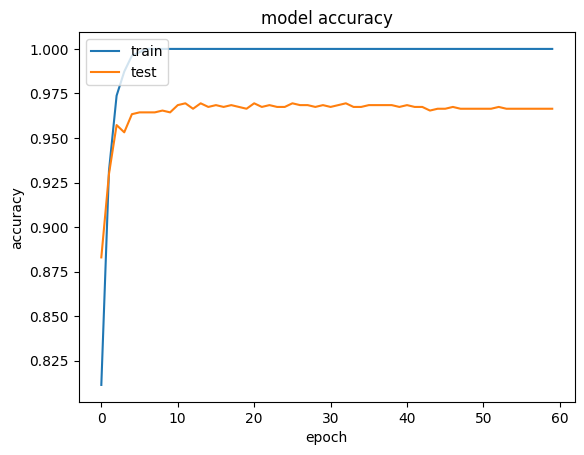

In [140]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

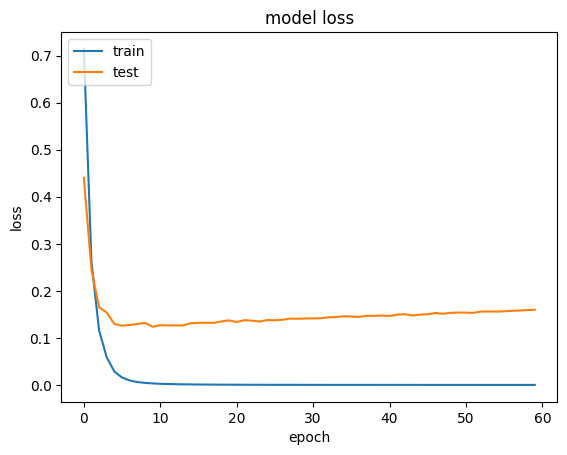

In [141]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

O modelo apresentou bons resultados no geral, mas aparenta estar sofrendo de underfitting para as categorias com poucas amostras. O desempenho foi ligeiramente pior que o modelo SVM e vale considerar que seu treinamento foi bem mais custoso quando comparado ao SVM.

# LSTM

Em seguida, temos a construção do modelo LSTM.

## Construção do Modelo

In [58]:
from keras.layers import LSTM

# Definying the model architecture
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, 300, input_length= INPUT_LENGTH, weights=[embedded_matrix], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))  # 9 is the number of classes

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 46, 300)           300600    
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 521409 (1.99 MB)
Trainable params: 220809 (862.54 KB)
Non-trainable params: 300600 (1.15 MB)
_________________________________________________________________


In [59]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
123/123 [==============================] - 11s 85ms/step - loss: 0.6872 - accuracy: 0.8120 - val_loss: 0.3472 - val_accuracy: 0.9003
Epoch 2/10
123/123 [==============================] - 11s 87ms/step - loss: 0.2139 - accuracy: 0.9438 - val_loss: 0.1739 - val_accuracy: 0.9522
Epoch 3/10
123/123 [==============================] - 11s 88ms/step - loss: 0.1205 - accuracy: 0.9649 - val_loss: 0.1092 - val_accuracy: 0.9705
Epoch 4/10
123/123 [==============================] - 11s 89ms/step - loss: 0.0650 - accuracy: 0.9827 - val_loss: 0.0732 - val_accuracy: 0.9807
Epoch 5/10
123/123 [==============================] - 11s 88ms/step - loss: 0.0424 - accuracy: 0.9888 - val_loss: 0.0637 - val_accuracy: 0.9847
Epoch 6/10
123/123 [==============================] - 11s 89ms/step - loss: 0.0284 - accuracy: 0.9901 - val_loss: 0.0643 - val_accuracy: 0.9827
Epoch 7/10
123/123 [==============================] - 11s 89ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0492 - val_accuracy:

## Avaliação do Modelo

In [60]:
predictions = model.predict(padded_test_data)
print(acc(encoded_test_labels, predictions))

26/26 [==============================] - 1s 18ms/step
0.9865853658536585


In [61]:
# Convert the one-hot encoded test labels back to categorical labels
y_test_labels = np.argmax(encoded_test_labels, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

# Generate the classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                     precision    recall  f1-score   support

  atis_abbreviation       0.94      0.94      0.94        33
      atis_aircraft       1.00      0.67      0.80         9
       atis_airfare       1.00      1.00      1.00        48
       atis_airline       1.00      1.00      1.00        38
        atis_flight       1.00      0.99      1.00       632
   atis_flight_time       1.00      1.00      1.00         1
atis_ground_service       1.00      1.00      1.00        36
      atis_quantity       0.38      1.00      0.55         3
              other       0.82      0.90      0.86        20

           accuracy                           0.99       820
          macro avg       0.90      0.94      0.90       820
       weighted avg       0.99      0.99      0.99       820



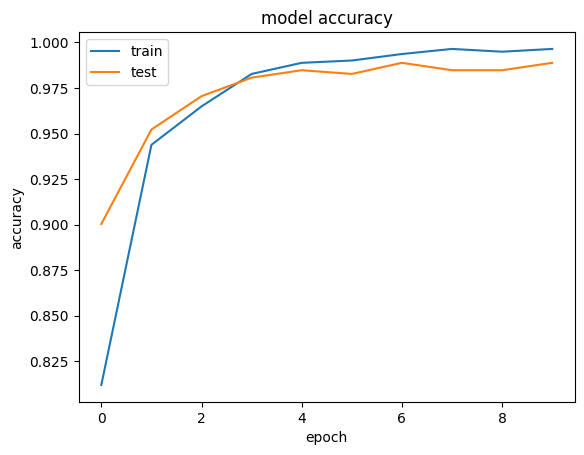

In [62]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

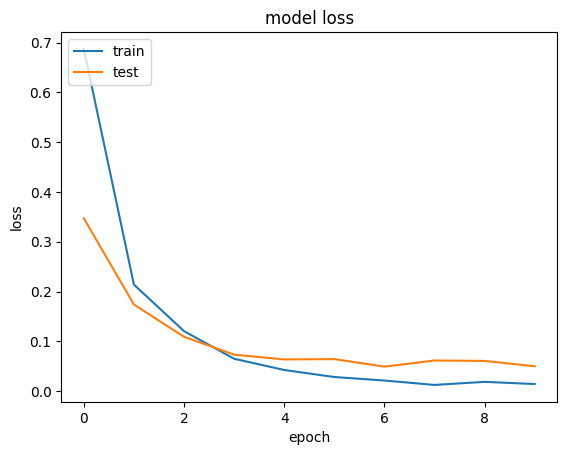

In [63]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Observamos que o modelo alcançou uma precisão elevada, com uma acurácia geral de 0,99 no conjunto de testes. Isso indica que o modelo está desempenhando muito bem na tarefa de classificação das intenções. Olhando para o relatório de classificação, vemos que a maioria das classes têm uma precisão e um recall de 1,00. Há, no entanto, algumas exceções notáveis, como a classe atis_quantity, que tem uma precisão significativamente mais baixa de 0,38, mas um recall de 1,00, indicando que, embora o modelo identifique todas as instâncias reais dessa classe, ele também está fazendo várias identificações incorretas. Isso provavelmente se dá por conta do número limitado de amostras disponíveis no nosso dataset.

# Avaliação

No geral, os três modelos apresentaram bons resultados na tarefa de classificação de intenções. O modelo com os melhores resultados é o LSTM. No entanto, vale considerar que foi o modelo que precisou de mais tempo para ser treinado. Algo já esperado, mas que poderia fazer diferença para um dataset mais robusto. Um ponto desfavorável foi o dataset desbalanceado, pois foi possível perceber piores resultados dos três modelos justamente nessas classes, especialmente "atis_flight_time" com apenas 1 amostra e "atis_quantity" com 3 amostras.

Por questões de infraestrutura das dependências utilizadas, o modelo Transformers foi treinado utilizando o Google Colab. A discussão sobre a avaliação dos 4 modelos pode ser observado nesse colab.